# Transfer Learning (VGG16) Notebook

### Lets import our dependencies

In [120]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras import Model
from PIL import Image

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np 
import os

### Load dataset
Function that loads a given dataset and pre-processes it before dumping it in their respective numpy-array.

In [121]:
def load_dataset(dataset):
    processed_images = []
    extracted_bboxes = []

    for item in os.listdir(dataset):
        if item.endswith('.jpg'):
            img_path = os.path.join(dataset, item)
            
            # Load the image and resize to 224x224
            img = img_to_array(load_img(img_path, target_size=(224, 224)))
            normalized_img = img.astype('float32') / 255.0  # Normalize image to retain original color
            processed_images.append(normalized_img)

            # Extract bounding box information from corresponding XML file
            xml_filename = os.path.splitext(item)[0] + '.xml'
            tree = ET.parse(os.path.join(dataset, xml_filename))
            root = tree.getroot()
            bndbox = root.find('.//bndbox')
            xmin, ymin, xmax, ymax = map(int, [bndbox.find(x).text for x in ['xmin', 'ymin', 'xmax', 'ymax']])
            img_shape = Image.open(img_path).size
            scale_x, scale_y = 224 / img_shape[0], 224 / img_shape[1]
            scaled_xmin, scaled_ymin, scaled_xmax, scaled_ymax = map(int, [xmin * scale_x, ymin * scale_y, xmax * scale_x, ymax * scale_y])
            extracted_bboxes.append([scaled_xmin, scaled_ymin, scaled_xmax, scaled_ymax])

    return np.array(processed_images), np.array(extracted_bboxes)

In [122]:
# Load and pre-process the dataset
Train_Images, Train_Bbox_Labels = load_dataset('../Dataset/train')
Test_Images,  Test_Bbox_Labels  = load_dataset('../Dataset/test')

### Custom Model: Object Detection with VGG16 Architecture
The custom model is built upon Keras' VGG16-model, a powerful convolutional neural network commonly used in image recognition tasks. This custom adaptation aims to detect a specific class within images by retraining the VGG16-model on a tailored dataset. The process involves substituting the last connected layer with a new output layer designed to predict the bounding box coordinates of the targeted object within the image. 

The code provided demonstrates the steps taken to fine-tune the VGG16 model. The initial action involves loading the VGG16 model without its top classification layers. Subsequently, modifications are made by appending a Flatten layer to transform the output into a one-dimensional tensor. Following this, a Dense layer with 256 units and a ReLU activation function is added. The final custom layer comprises 4 units and employs a linear activation function to generate predictions for bounding box coordinates. The model is subsequently compiled using the mean squared error as the loss function and the Adam optimizer.

In [123]:
# Load VGG16 model without the top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=[224, 224, 3])

# Flatten the output and add custom output layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)

# Output layer for object detection
bbox_output = Dense(4, activation='linear')(x) # Bounding box coordinate predictions

# Create a new model with custom input and output layer
Custom_VGG16 = Model(inputs=base_model.input, outputs=bbox_output)

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
Custom_VGG16.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

## Evaluating Custom VGG16 Model and Determining Epochs
To evaluate the custom VGG16 model's performance, an experiment was conducted, comparing test images and their ground truth bounding box labels against the model's outputs. This assessment computed Intersection over Union (IoU) for each image and gauged the IoU across the entire training set.

This validation process not only facilitated visual comparisons between model predictions and actual labels but also quantified accuracy using IoU scores, providing comprehensive insights into the model's dataset-wide performance.

The model excels in accurately extracting cars from images, especially in single-object scenarios, aligning well with its design as a single-box detection model. Challenges arise when multiple objects are present within an image or when the sky is dark grey, leading to an overall decline in the IoU score. Presently, after ten epochs, the model achieves an overall IoU score of 78.8%.

Regarding the selection of epochs, an analysis of loss and IoU accuracy trends during training revealed that the loss trend had minimal impact on decision-making. Consequently, emphasis shifted solely to the IoU score to determine the optimal number of epochs. The decision was made to train the model for ten epochs. Graphical representations clearly indicate that the IoU accuracy plateaus after approximately eight epochs, suggesting diminishing improvements in loss reduction beyond this point.

In [124]:
def calculate_IoU_Percentage(box1, box2):
    """
    Calculate IoU (Intersection over Union) between two bounding boxes.
    Each bounding box is represented as a tuple (xmin, ymin, xmax, ymax),
    """

    # Calculate intersection coordinates
    xmin_inter = max(box1[0], box2[0])
    ymin_inter = max(box1[1], box2[1])
    xmax_inter = min(box1[2], box2[2])
    ymax_inter = min(box1[3], box2[3])

    # Calculate intersection area
    intersection_area = max(0, xmax_inter - xmin_inter + 1) * max(0, ymax_inter - ymin_inter + 1)

    # Calculate area of each bounding box
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # Calculate union area
    union_area = box1_area + box2_area - intersection_area

    # Calculate and return IoU %
    return (intersection_area / union_area) * 100

In [137]:
def plot_IoU(IoU_Array):
    plt.plot(IoU_Array, marker='o', linestyle='-')
    plt.title('IoU Scores across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('IoU Score')
    plt.show()

In [138]:
IoU_Array = [0]

for epoch in range(10):
    # Training the model once for n amount of epochs 
    hist = Custom_VGG16.fit(Train_Images, Train_Bbox_Labels, epochs=1, batch_size=32, verbose = 0)
    score=0

    # Loop through the image filenames and process each image
    for index, item in enumerate(Test_Images):
        image = np.expand_dims(Test_Images[index], axis=0)
        Pred_Bbox_Label = tuple(map(int, Custom_VGG16.predict(image)[0]))
        IoU = calculate_IoU_Percentage(Pred_Bbox_Label, Test_Bbox_Labels[index])
        score += IoU

    # print(f"Total IoU Score: {score/len(Test_Images):.1f}%")
    IoU_Array.append(score/len(Test_Images))

plot_IoU(IoU_Array)

In [131]:
def plot_bbox_img(img, bounding_boxes_list, IoU):

    fig, image = plt.subplots(nrows=1, ncols=2)
    
    for index, item in enumerate(bounding_boxes_list):
        xmin, ymin, xmax, ymax = bounding_boxes_list[index]

        image[index].imshow(img)
        bbox = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
        image[index].add_patch(bbox)
        image[index].axis("off")
    
    image[0].set_title("Ground Truth\n-------------------------\n")
    image[1].set_title(f"Predicted\n-------------------------\nIoU Score: {IoU:.1f}%")

    plt.show()

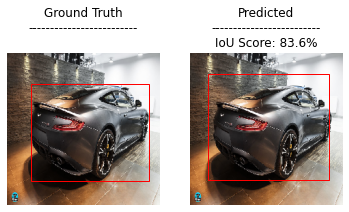

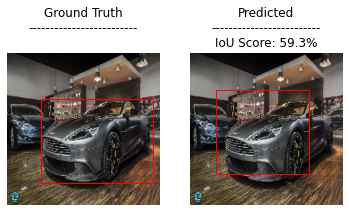

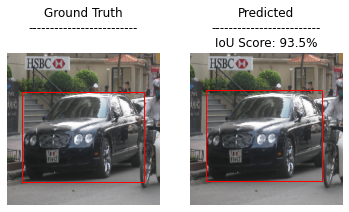

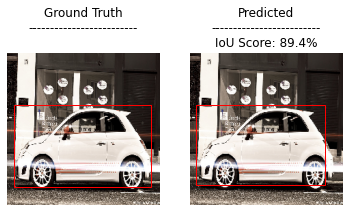

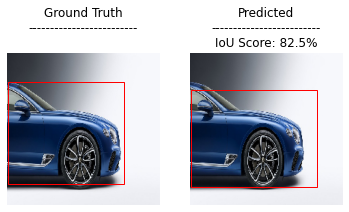

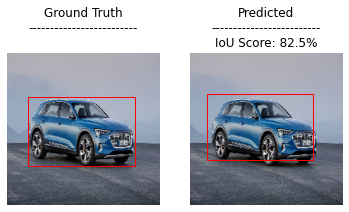

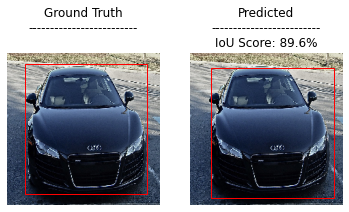

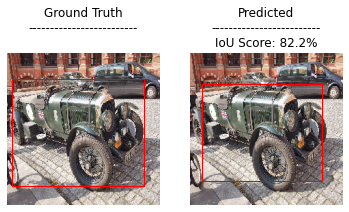

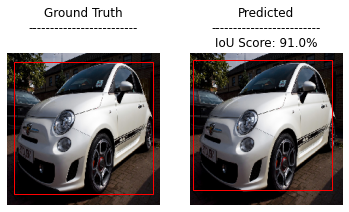

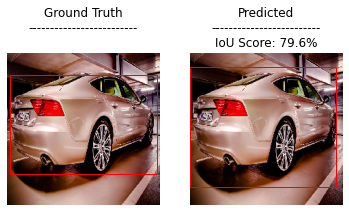

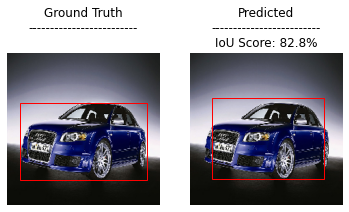

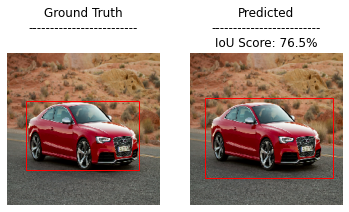

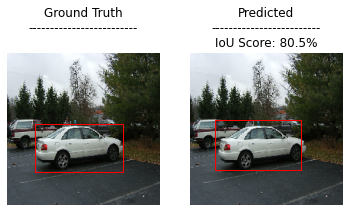

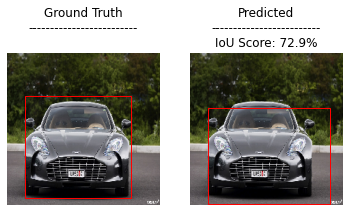

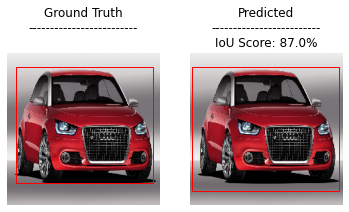

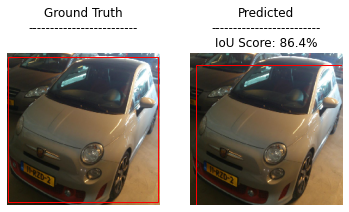

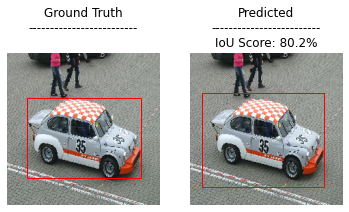

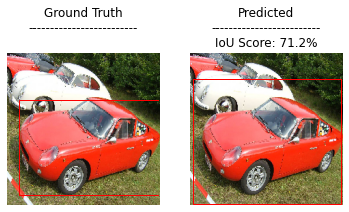

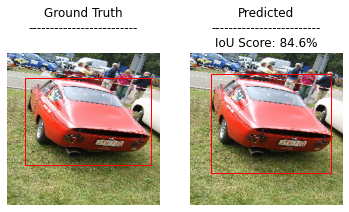

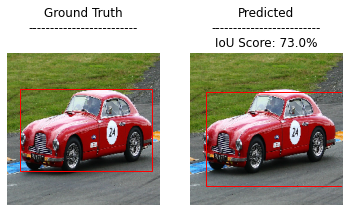

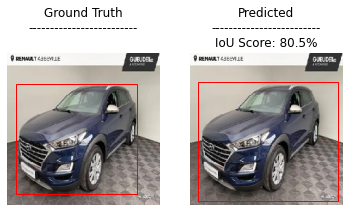

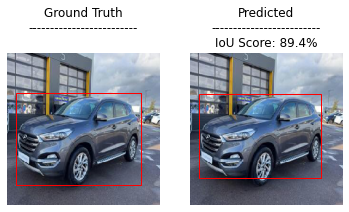

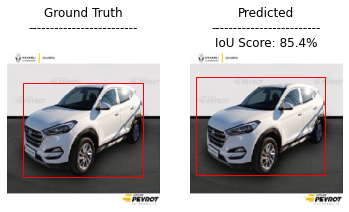

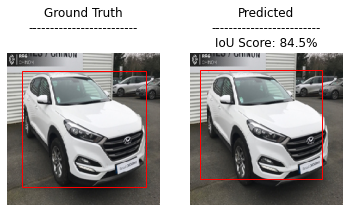

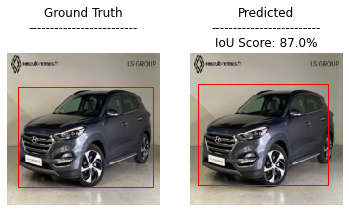

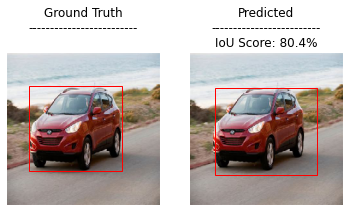

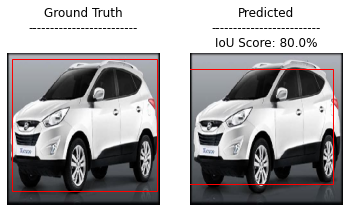

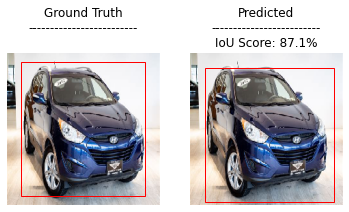

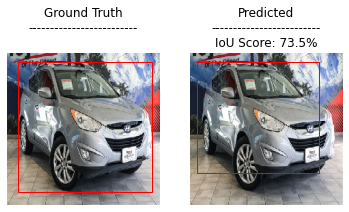

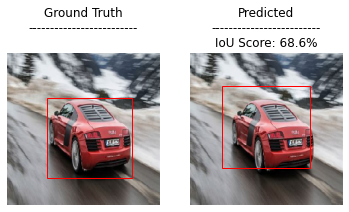

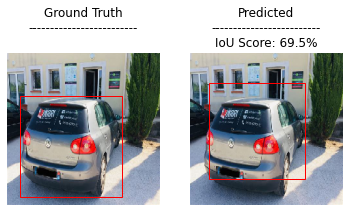

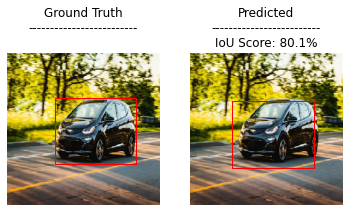

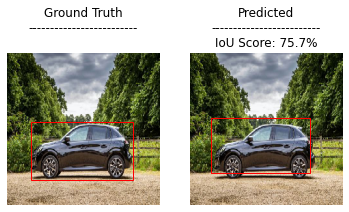

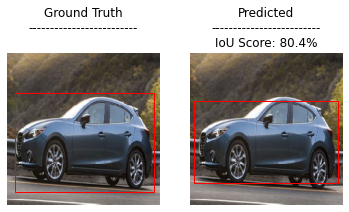

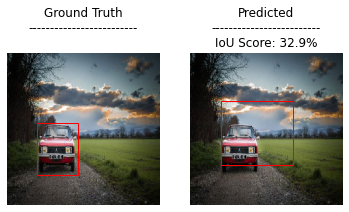

Total IoU Score: 77.4%


In [132]:
score=0
# Loop through the image filenames and process each image
for index, item in enumerate(Test_Images):
    image = np.expand_dims(Test_Images[index], axis=0)
    Pred_Bbox_Label = tuple(map(int, Custom_VGG16.predict(image)[0]))
    IoU = calculate_IoU_Percentage(Pred_Bbox_Label, Test_Bbox_Labels[index])
    score += IoU
    plot_bbox_img(Test_Images[index], [Test_Bbox_Labels[index], Pred_Bbox_Label], IoU)

print(f"Total IoU Score: {score/len(Test_Images):.1f}%")